In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import cv2

In [3]:
import os
import pathlib

In [4]:
data_path = pathlib.Path("libras")
data_path = os.path.join(data_path, os.listdir(data_path)[1])
print(data_path)

libras\train


In [5]:
# data_path_test = pathlib.Path("asl_alphabet_test")
# data_path_test = os.path.join(data_path_test, os.listdir(data_path_test)[0])
# print(data_path_test)

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="training",
    shuffle=True,
    image_size = (64, 64),
    batch_size = 32,
    color_mode='grayscale'
)

Found 34714 files belonging to 21 classes.
Using 27772 files for training.


In [7]:
test = tf.keras.preprocessing.image_dataset_from_directory(
    data_path, seed=123,
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    image_size = (64, 64),
    batch_size = 32,
    color_mode='grayscale'
)

Found 34714 files belonging to 21 classes.
Using 6942 files for validation.


In [8]:
class_names = dataset.class_names

In [9]:
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'I',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y']

### Tratando as imagens

Escala Cinza

https://stackoverflow.com/questions/55572325/how-can-i-use-neutral-network-with-gray-scale-images-in-keras

In [10]:
# def to_grayscale_then_rgb(image):
#     image = tf.image.rgb_to_grayscale(image)
#     image = tf.image.grayscale_to_rgb(image)
#     return image

In [11]:
# tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1/255,
#     preprocessing_function=to_grayscale_then_rgb()
# )

In [12]:
dataset.element_spec

(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [13]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(data_path, color_mode='grayscale')

In [14]:
dataset.element_spec

(TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

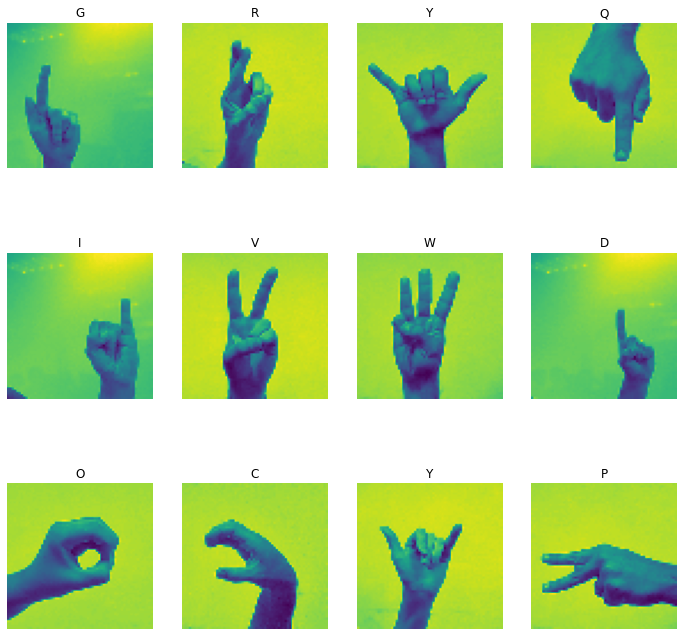

In [15]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [16]:
# def split_data(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=50):
#     assert (train_split + test_split + val_split) == 1
    
#     ds_size = len(ds)
#     if shuffle:
#         ds.shuffle(shuffle_size, seed=123)
        
#     train_size = int(ds_size * train_split)
#     val_size = int(ds_size * val_split)
    
#     train_ds = ds.take(train_size)
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, test_ds, val_ds

In [17]:
# train_ds, test_ds, val_ds = split_data(dataset)


In [18]:
# train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Outro tratamento

### Pré-processamento + mapped_function

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = dataset.map(lambda x,y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(64, 64),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
# vgg16 = tf.keras.applications.VGG16(
#     include_top=False,
#     weights="imagenet")

# vgg16.trainable = False

# inputs = tf.keras.Input(shape=(64, 64, 3))
# x = tf.keras.applications.vgg16.preprocess_input(
#     inputs, data_format=None)

# x = vgg16(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(4096, activation="relu")(x)
# x = tf.keras.layers.Dense(4096, activation="relu")(x)
# outputs = tf.keras.layers.Dense(21, activation="softmax")(x)
# model = tf.keras.Model(inputs, outputs)

In [22]:
#modelling

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
  layers.Rescaling(1./255, input_shape=(64, 64, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(21,activation='softmax')
])

Adicionar Dropout
tf.keras.layers.Dropout(0.2)(x)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)       

In [24]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)

In [25]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=6, verbose=1, mode='auto')

cb = [checkpoint, early]

In [27]:
# tf.config.experimental.list_physical_devices('GPU')

In [28]:
# history = model.fit(train_ds, epochs=5, validation_data=test)

In [29]:
# model_libras_2 EU PERDI, EXECUTEI SEM QUERER, MAS A ACURÁCIA TAVA MAIOR, PASSAND0 DOS 0.92, PORÉM NO OUTRO, OS GRÁFICOS SAÍRAM NORMAIS PQ O TREINO TÁ ACOMPANHANDO O TESTE NO INÍCIO
# model.evaluate(test)

In [30]:
# model_libras_color_mode_grayscale.h5
# model.evaluate(test)

In [31]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Perda por épocas')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.legend(['treino', 'teste'])

In [32]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Acurácia por épocas')
# plt.xlabel('epochs')
# plt.ylabel('accuracy')
# plt.legend(['treino', 'validação'])

### Com 15 epochs

In [33]:
history = model.fit(train_ds, epochs=120, validation_data=test)


Epoch 1/120
868/868 [==============================] - 57s 65ms/step - loss: 2.1946 - accuracy: 0.3305 - val_loss: 1.1318 - val_accuracy: 0.6527
Epoch 2/120
868/868 [==============================] - 58s 67ms/step - loss: 0.8467 - accuracy: 0.7477 - val_loss: 0.6433 - val_accuracy: 0.8042
Epoch 3/120
868/868 [==============================] - 58s 67ms/step - loss: 0.5003 - accuracy: 0.8475 - val_loss: 0.6231 - val_accuracy: 0.7950
Epoch 4/120
868/868 [==============================] - 60s 69ms/step - loss: 0.3463 - accuracy: 0.8895 - val_loss: 0.5777 - val_accuracy: 0.8222
Epoch 5/120
868/868 [==============================] - 62s 72ms/step - loss: 0.2690 - accuracy: 0.9151 - val_loss: 0.5476 - val_accuracy: 0.8224
Epoch 6/120
868/868 [==============================] - 63s 72ms/step - loss: 0.2146 - accuracy: 0.9290 - val_loss: 0.2392 - val_accuracy: 0.9183
Epoch 7/120
868/868 [==============================] - 62s 72ms/step - loss: 0.1769 - accuracy: 0.9418 - val_loss: 0.2076 - val_ac

In [38]:
# model_libras_color_mode_grayscale.h5 COM 15
model.evaluate(test)

217/217 [==============================] - 5s 22ms/step - loss: 0.0253 - accuracy: 0.9922


[0.025309380143880844, 0.9922212362289429]

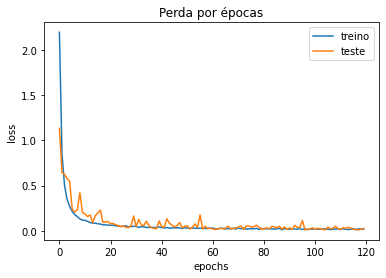

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda por épocas')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['treino', 'teste'])

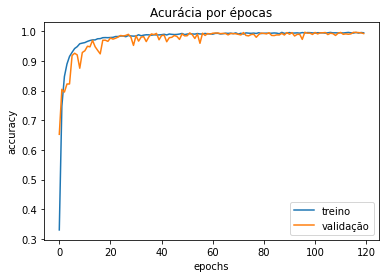

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia por épocas')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['treino', 'validação'])

In [39]:
model.save('model_libras_color_mode_grayscale_120epochs.h5')